In [ ]:
import numpy as np

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

class LSTMCell:
    def __init__(self, input_size, hidden_size, output_size=1, learning_rate=0.001):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate

        # Initialize weights with small values to avoid overflow/underflow
        self.W_f = np.random.randn(hidden_size, hidden_size + input_size) * 0.01
        self.b_f = np.zeros((hidden_size, 1))
        self.W_i = np.random.randn(hidden_size, hidden_size + input_size) * 0.01
        self.b_i = np.zeros((hidden_size, 1))
        self.W_C = np.random.randn(hidden_size, hidden_size + input_size) * 0.01
        self.b_C = np.zeros((hidden_size, 1))
        self.W_o = np.random.randn(hidden_size, hidden_size + input_size) * 0.01
        self.b_o = np.zeros((hidden_size, 1))
        self.W_y = np.random.randn(output_size, hidden_size) * 0.01
        self.b_y = np.zeros((output_size, 1))
        self.h = np.zeros((hidden_size, 1))
        self.C = np.zeros((hidden_size, 1))

    def sigmoid(self, x):
        # Clip input to avoid overflow in exp
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        combined = np.concatenate((self.h, x), axis=0)
        f_t = self.sigmoid(np.dot(self.W_f, combined) + self.b_f)
        i_t = self.sigmoid(np.dot(self.W_i, combined) + self.b_i)
        C_tilde = np.tanh(np.dot(self.W_C, combined) + self.b_C)
        self.C = f_t * self.C + i_t * C_tilde
        o_t = self.sigmoid(np.dot(self.W_o, combined) + self.b_o)
        self.h = o_t * np.tanh(self.C)
        return self.h

    def predict_output(self):
        y = np.dot(self.W_y, self.h) + self.b_y
        return y

    def train(self, input_sequences, target_sequence, epochs=100):
        m = target_sequence.shape[1]  # Number of time steps

        for epoch in range(epochs):
            total_loss = 0

            # Initialize gradients
            dW_f = np.zeros_like(self.W_f)
            dW_i = np.zeros_like(self.W_i)
            dW_C = np.zeros_like(self.W_C)
            dW_o = np.zeros_like(self.W_o)
            dW_y = np.zeros_like(self.W_y)
            db_f = np.zeros_like(self.b_f)
            db_i = np.zeros_like(self.b_i)
            db_C = np.zeros_like(self.b_C)
            db_o = np.zeros_like(self.b_o)
            db_y = np.zeros_like(self.b_y)

            for t in range(m):
                x_t = input_sequences[:, t].reshape(-1, 1)
                h_t = self.forward(x_t)
                y_pred = self.predict_output()
                loss = 0.5 * (y_pred - target_sequence[:, t])**2
                total_loss += loss

                # Backward pass: compute gradients
                dy = y_pred - target_sequence[:, t]
                dW_y += np.dot(dy, self.h.T)
                db_y += dy

                dh = np.dot(self.W_y.T, dy)
                do = dh * np.tanh(self.C)
                dC = dh * self.h * (1 - np.tanh(self.C)**2)
                di = dC * self.C
                df = dC * self.C
                dC_tilde = dC * self.h

                combined_input = np.concatenate((self.h, x_t), axis=0)
                dcombined = np.dot(self.W_f.T, df) + np.dot(self.W_i.T, di) + np.dot(self.W_C.T, dC_tilde) + np.dot(self.W_o.T, do)
                dW_f += np.dot(df * (self.h - self.C), combined_input.T)
                db_f += df
                dW_i += np.dot(di * (self.h - self.C), combined_input.T)
                db_i += di
                dW_C += np.dot(dC_tilde * (self.h - self.C), combined_input.T)
                db_C += dC_tilde
                dW_o += np.dot(do * (self.h - self.C), combined_input.T)
                db_o += do

            # Update weights after each epoch
            self.W_f -= self.learning_rate * dW_f
            self.b_f -= self.learning_rate * db_f
            self.W_i -= self.learning_rate * dW_i
            self.b_i -= self.learning_rate * db_i
            self.W_C -= self.learning_rate * dW_C
            self.b_C -= self.learning_rate * db_C
            self.W_o -= self.learning_rate * dW_o
            self.b_o -= self.learning_rate * db_o
            self.W_y -= self.learning_rate * dW_y
            self.b_y -= self.learning_rate * db_y

            # Print loss to track progress
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss[0, 0] / m}")

    def predict(self, input_sequences):
        m = input_sequences.shape[1]  # Number of time steps
        predictions = []

        for t in range(m):
            x_t = input_sequences[:, t].reshape(-1, 1)
            h_t = self.forward(x_t)
            y_pred = self.predict_output()
            predictions.append(y_pred.flatten())

        return np.array(predictions)

# Load the data for prediction
df2 = pd.read_csv("result_dataset_more_cols_of_one_company.csv")
df2c = df2
df2 = df2[:200]
input_df2 = df2[['Open', 'High', 'Low', 'Adj Close', 'Volume']]
target_df2 = df2c[["Close"]]
target_df2 = target_df2[:200]

# Scaling the input and target data
scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

input_sequences2_scaled = scaler_x.fit_transform(input_df2).T
target_sequence2_scaled = scaler_y.fit_transform(target_df2).T

# Initialize and train the LSTM model
model = LSTMCell(input_size=input_sequences2_scaled.shape[0], hidden_size=100)  # Increased hidden size

# Train the model on the input and target sequences
model.train(input_sequences2_scaled, target_sequence2_scaled, epochs=3000)

# Predicting
predicted_close_scaled = model.predict(input_sequences2_scaled)

# Reshape the predictions and inverse-transform to the original scale
predicted_close_scaled = predicted_close_scaled.T
predicted_close = scaler_y.inverse_transform(predicted_close_scaled)
predicted_close = predicted_close.flatten().reshape(-1, 1)

# Convert predictions to DataFrame
predicted_close_df = pd.DataFrame(predicted_close, columns=["Predicted_Close"])
print(predicted_close_df)

# Accuracy function implementation
def accuracy_function(actual, predicted, tolerance=0.05):
    """
    Calculate the percentage of predictions that are within a specified tolerance range of the actual values.
    
    :param actual: The actual values (numpy array)
    :param predicted: The predicted values (numpy array)
    :param tolerance: The tolerance within which a prediction is considered accurate (default is 5%)
    :return: Accuracy as a percentage of accurate predictions
    """
    percentage_error = np.abs((predicted - actual) / actual)
    accurate_predictions = np.sum(percentage_error <= tolerance)
    accuracy = (accurate_predictions / len(actual)) * 100
    return accuracy

# Calculate custom accuracy
actual_close = target_df2.to_numpy()
accuracy = accuracy_function(actual_close, predicted_close, tolerance=0.1) #changed from 0.05 to 0.1

print(f"Accuracy: {accuracy}%")
# Calculate accuracy using regression metrics
actual_close = target_df2.to_numpy()

# Mean Squared Error
mse = mean_squared_error(actual_close, predicted_close)
# Mean Absolute Error
mae = mean_absolute_error(actual_close, predicted_close)
# R-squared
r2 = r2_score(actual_close, predicted_close)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")


In [2]:
#############################################################################################################################################################################

df2t = pd.read_csv("result_dataset_more_cols_of_one_company.csv")
df2t = df2t[200:300]
input_df2t = df2t[['Open', 'High', 'Low', 'Adj Close', 'Volume']]
target_df2t = df2t[["Close"]]

input_sequences2_scaled_t = scaler_x.fit_transform(input_df2t).T
target_sequence2_scaled_t = scaler_y.fit_transform(target_df2t).T

# Predicting
predicted_close_scaled = model.predict(input_sequences2_scaled_t)

# Reshape the predictions and inverse-transform to the original scale
predicted_close_scaled = predicted_close_scaled.T
predicted_close = scaler_y.inverse_transform(predicted_close_scaled)
predicted_close = predicted_close.flatten().reshape(-1, 1)

# Convert predictions to DataFrame
predicted_close_df = pd.DataFrame(predicted_close, columns=["Predicted_Close"])
print(predicted_close_df)

# Accuracy function implementation
def accuracy_function(actual, predicted, tolerance=0.1):
    percentage_error = np.abs((predicted - actual) / actual)
    within_tolerance = np.sum(percentage_error <= tolerance)
    accuracy_percentage = within_tolerance / len(actual) * 100
    return accuracy_percentage

# Accuracy calculation
actual_values = target_df2t.values.flatten()
predicted_values = predicted_close.flatten()
accuracy = accuracy_function(actual_values, predicted_values)
print(f"Accuracy: {accuracy}%")


#############################################################################################################################################################################

    Predicted_Close
0          0.380309
1          0.380564
2          0.381034
3          0.382281
4          0.382506
..              ...
95         0.363636
96         0.364417
97         0.364440
98         0.364431
99         0.363266

[100 rows x 1 columns]
Accuracy: 77.0%


In [3]:
df2c.shape

(7553, 8)

In [4]:
df2t_cpy = pd.read_csv("result_dataset_more_cols_of_one_company.csv")
min(df2t_cpy["Close"]), max(df2t_cpy["Close"])

(0.1155129969120025, 234.82000732421875)

In [5]:
print(predicted_close_df)

    Predicted_Close
0          0.380309
1          0.380564
2          0.381034
3          0.382281
4          0.382506
..              ...
95         0.363636
96         0.364417
97         0.364440
98         0.364431
99         0.363266

[100 rows x 1 columns]


In [6]:
print("Unique values in predictions:", np.unique(predicted_close))

Unique values in predictions: [0.35449164 0.35466013 0.3548092  0.35501493 0.35503558 0.35513599
 0.35517256 0.35543896 0.35551435 0.35561699 0.35600782 0.35613735
 0.35651921 0.35677428 0.35678776 0.35728332 0.35732385 0.35750683
 0.35773161 0.35794142 0.3583637  0.35882831 0.35883974 0.35887304
 0.358957   0.35906128 0.35916721 0.35919857 0.35929245 0.35969903
 0.35974872 0.35976843 0.35989475 0.36017179 0.36045159 0.3608369
 0.36115895 0.36259939 0.36303452 0.36326559 0.36334167 0.36352983
 0.36363632 0.36377613 0.36441713 0.3644312  0.36444017 0.36449447
 0.36496192 0.36502929 0.36591837 0.36657904 0.36667718 0.36721623
 0.36936293 0.37103297 0.37132514 0.37140427 0.37165636 0.37174804
 0.3718194  0.37200635 0.37205528 0.37209108 0.37229815 0.37240725
 0.37250323 0.37280249 0.37289376 0.37324626 0.37362032 0.37365174
 0.37377317 0.3739478  0.37422033 0.374344   0.37439102 0.37441071
 0.37441877 0.37442367 0.37449049 0.37465679 0.37508048 0.37513016
 0.37525884 0.37592126 0.37595196

In [7]:
actual_scaler = MinMaxScaler(feature_range=(min(df2t_cpy["Close"]), max(df2t_cpy["Close"])))
actual_close_scaled_ = actual_scaler.fit_transform(actual_close.reshape(-1, 1))
# Convert scaled predicted values to DataFrame (optional)
actual_close_df_scaled = pd.DataFrame(actual_close_scaled_.flatten(), columns=["Actual_Close (Scaled)"])

In [8]:
# Create a new scaler for predicted values (optional)
predicted_scaler = MinMaxScaler(feature_range=(min(df2t_cpy["Close"]), max(df2t_cpy["Close"])))

# Scale the predicted values (optional)
predicted_close_scaled = predicted_scaler.fit_transform(predicted_close.reshape(-1, 1))

# Convert scaled predicted values to DataFrame (optional)
predicted_close_df_scaled = pd.DataFrame(predicted_close_scaled.flatten(), columns=["Predicted_Close (Scaled)"])

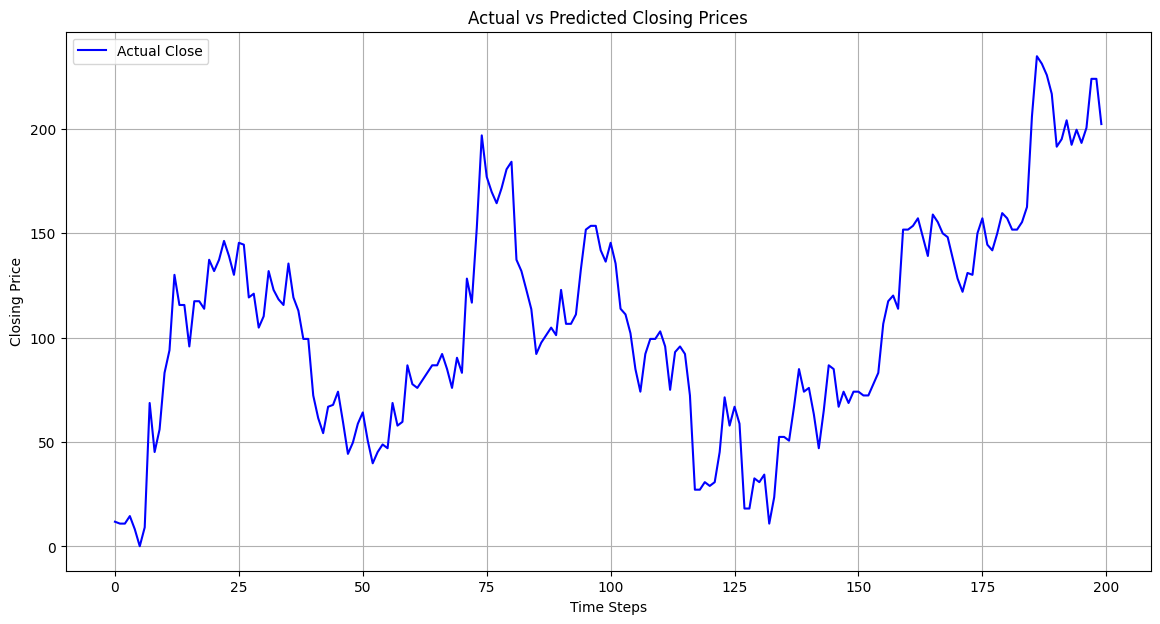

In [9]:

import matplotlib.pyplot as plt

# Create a time index for the x-axis (assuming it's just a range of integers for now)
time_index = np.arange(len(actual_close))
# Plotting
plt.figure(figsize=(14, 7))
plt.plot(time_index, actual_close_df_scaled["Actual_Close (Scaled)"], label='Actual Close', color='blue')
#plt.plot(time_index, predicted_close_df_scaled["Predicted_Close (Scaled)"], label='Predicted Close', color='orange')
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.legend()
plt.grid()
plt.show()


ValueError: x and y must have same first dimension, but have shapes (200,) and (100,)

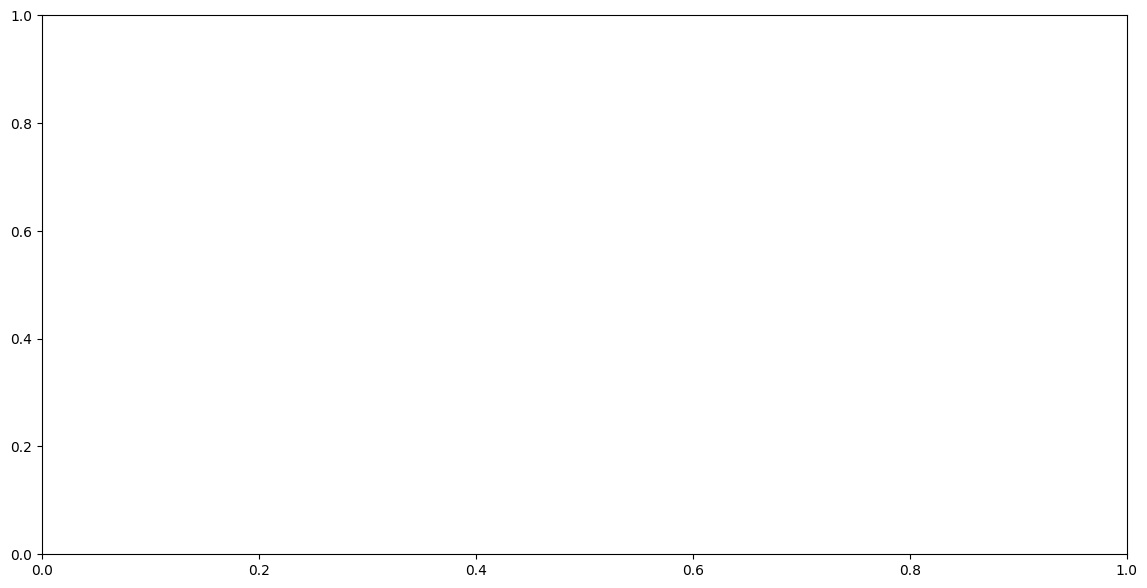

In [10]:
# Plotting
plt.figure(figsize=(14, 7))
#plt.plot(time_index, actual_close_df["Actual_Close"], label='Actual Close', color='blue')
plt.plot(time_index, predicted_close_df_scaled["Predicted_Close (Scaled)"], label='Predicted Close', color='orange')
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.legend()
plt.grid()
plt.show()

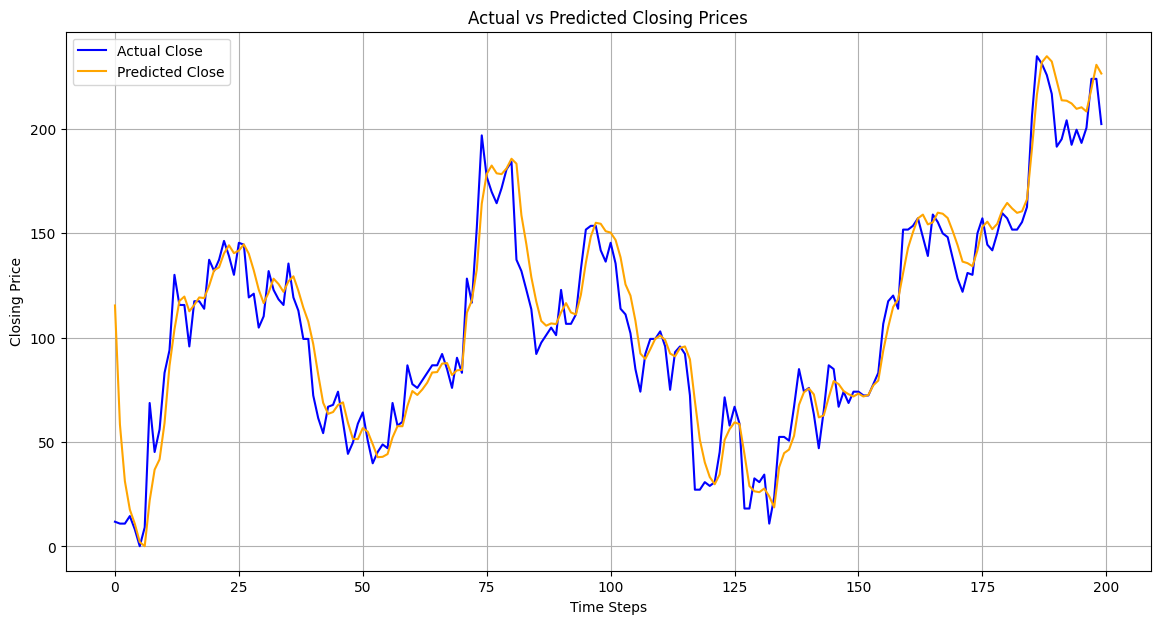

In [30]:
# Plotting
plt.figure(figsize=(14, 7))
plt.plot(time_index, actual_close_df_scaled["Actual_Close (Scaled)"], label='Actual Close', color='blue')
plt.plot(time_index, predicted_close_df_scaled["Predicted_Close (Scaled)"], label='Predicted Close', color='orange')
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.legend()
plt.grid()
plt.show()

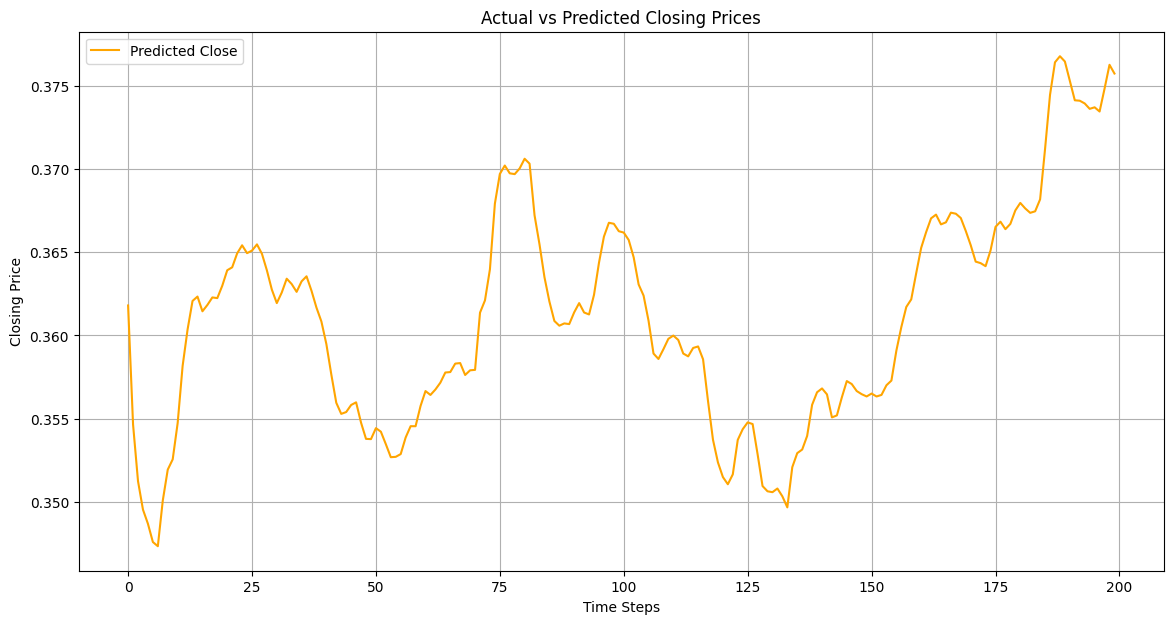

In [31]:
import matplotlib.pyplot as plt

# Assuming actual_close is scaled back to original values and is already computed
actual_close = scaler_y.inverse_transform(target_sequence2_scaled.T)  # Reshape to match dimensions

# Convert to DataFrame for easier plotting
actual_close_df = pd.DataFrame(actual_close, columns=["Actual_Close"])
predicted_close_df = pd.DataFrame(predicted_close, columns=["Predicted_Close"])

# Create a time index for the x-axis (assuming it's just a range of integers for now)
time_index = np.arange(len(actual_close))

# Plotting
plt.figure(figsize=(14, 7))
#plt.plot(time_index, actual_close_df["Actual_Close"], label='Actual Close', color='blue')
plt.plot(time_index, predicted_close_df["Predicted_Close"], label='Predicted Close', color='orange')
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.legend()
plt.grid()
plt.show()


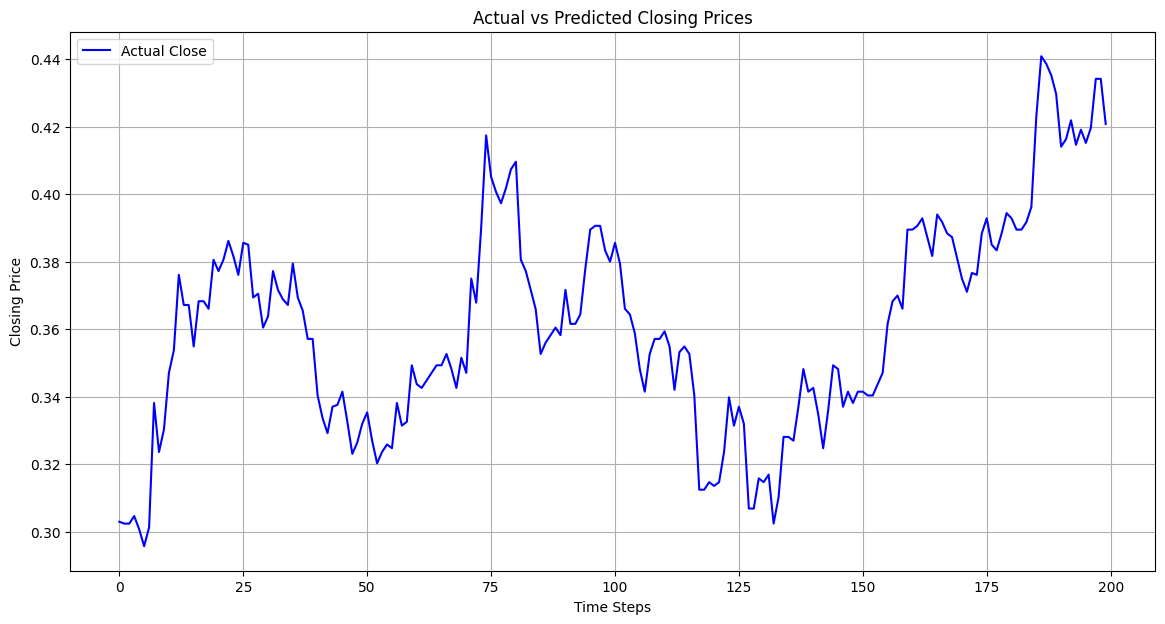

In [32]:
# Plotting
plt.figure(figsize=(14, 7))
plt.plot(time_index, actual_close_df["Actual_Close"], label='Actual Close', color='blue')
#plt.plot(time_index, predicted_close_df["Predicted_Close"], label='Predicted Close', color='orange')
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.legend()
plt.grid()
plt.show()

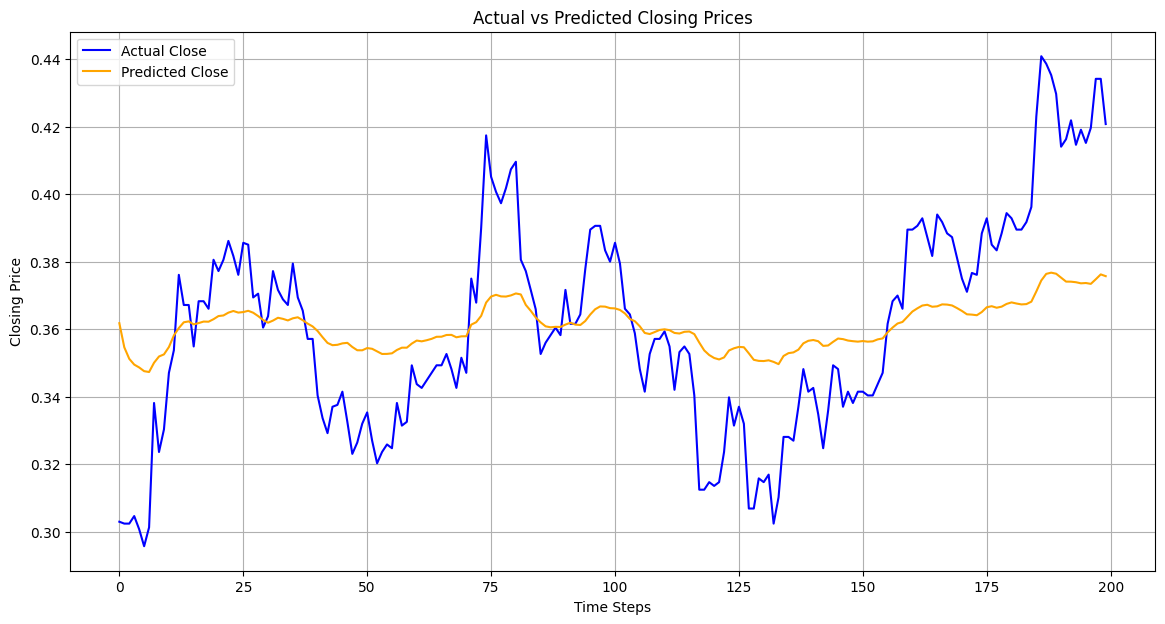

In [33]:
actual_close_df = pd.DataFrame(actual_close, columns=["Actual_Close"])
predicted_close_df = pd.DataFrame(predicted_close, columns=["Predicted_Close"])

# Create a time index for the x-axis (assuming it's just a range of integers for now)
time_index = np.arange(len(actual_close))

# Plotting - No need to scale actual_close (already scaled during training)
plt.figure(figsize=(14, 7))
plt.plot(time_index, actual_close_df["Actual_Close"], label='Actual Close', color='blue')
plt.plot(time_index, predicted_close_df["Predicted_Close"], label='Predicted Close', color='orange')
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.legend()
plt.grid()
plt.show()

In [1]:
# Create a new scaler for predicted values (optional)
predicted_scaler = MinMaxScaler(feature_range=(min(actual_close), max(actual_close)))

# Scale the predicted values (optional)
predicted_close_scaled = predicted_scaler.fit_transform(predicted_close.reshape(-1, 1))

# Convert scaled predicted values to DataFrame (optional)
predicted_close_df_scaled = pd.DataFrame(predicted_close_scaled.flatten(), columns=["Predicted_Close (Scaled)"])

# Plotting - Scale predicted values if desired
plt.figure(figsize=(14, 7))
plt.plot(time_index, actual_close_df["Actual_Close"], label='Actual Close', color='blue')
# Plot scaled predicted values or original predicted values depending on your preference
# plt.plot(time_index, predicted_close_df["Predicted_Close"], label='Predicted Close', color='orange')
plt.plot(time_index, predicted_close_df_scaled["Predicted_Close (Scaled)"], label='Predicted Close (Scaled)', color='orange')
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.legend()
plt.grid()
plt.show()

NameError: name 'MinMaxScaler' is not defined